In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

In [2]:
# Pandas display options
pd.set_option('display.max_rows', 1200)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 100)

In [71]:
# read each dataset in a dataframe
df_abide2 = pd.read_csv('/project/data/ABIDE2/phenotypics.csv')
df_adhd200 = pd.read_csv('/project/data/ADHD200/phenotypics.csv')
df_bhrc = pd.read_csv('/project/data/INPD/phenotypics.csv')
df_abcd = pd.read_csv('/project/data/ABCD/phenotypics.csv')

# ABIDE-II adjusts
df_abide2['dataset'] = 'ABIDE-II'
df_abide2['apd'] = df_abide2['DX_GROUP'].replace(2,0) # any psychiatric disorder
df_abide2['cbcl_tot'] = -999
df_abide2 = df_abide2.rename(columns={"SUB_ID": "subjectid", "SEX_BIN": "sex_bin", "AGE_AT_SCAN": "age_y", 
                                      "SITE_ID_BIN": "site"})
# ADHD-200 adjusts
df_adhd200['dataset'] = 'ADHD-200'
df_adhd200['apd'] = df_adhd200['DX'].replace([2,3],1) # any psychiatric disorder
df_adhd200['cbcl_tot'] = -999
df_adhd200 = df_adhd200.rename(columns={"SCANDIR_ID": "subjectid", "GENDER": "sex_bin", "AGE": "age_y",
                                       "SITE": "site"})
# BHRCS adjusts
df_bhrc['dataset'] = 'BHRCS'
df_bhrc['gender'] = df_bhrc['gender'].replace(2,0)
df_bhrc['apd'] = df_bhrc['dcany'].replace(2,1) # any psychiatric disorder
df_bhrc['cbcl_tot'] = df_bhrc['cl_tot']
df_bhrc = df_bhrc.rename(columns={"gender": "sex_bin", "age": "age_y",
                                  "state": "site"})
# ABCD adjusts
df_abcd['dataset'] = 'ABCD'
df_abcd['cbcl_tot'] = df_abcd['cbcl_scr_syn_totprob_r']
df_abcd = df_abcd.rename(columns={"subjectkey": "subjectid", "age": "age_y", "diag_any": "apd",
                                 "scanner_serialnumber_bin": "site"})

# append data to the same dataframe
df = pd.DataFrame()
for dataset in ['df_abide2','df_adhd200','df_bhrc','df_abcd']:
    df = df.append(eval(dataset+"[['dataset','sex_bin','age_y','apd','cbcl_tot']]"), ignore_index=True)
    
# map gender to a string feature
df['gender'] = np.select([df['sex_bin']==0, df['sex_bin']==1], 
                         ['female', 'male'], 
                         'other')

# map gender to a string feature
df['psy'] = np.select([df['apd']==0, df['apd']==1], 
                         ['Typical development (TD)','Psychiatric diagnostic (PD)'], 
                         'other')

# reverse ordering
df = df.reindex(index=df.index[::-1])

In [60]:
# get demographic info
list_demogs = []
for dataset in ['ABIDE-II','ADHD-200','BHRCS','ABCD']:
    # prepare variables
    condition = df['dataset'] == dataset
    N = df[condition]['gender'].count()
    male_perc = np.round((df[condition & df['sex_bin']==1]['gender'].count() / N), 3)
    female_perc = np.round((1 - male_perc), 3)
    age_mean = np.round(df[condition]['age_y'].mean(), 1)
    age_sd = np.round(df[condition]['age_y'].std(), 1)
    age_range = str(np.round(df[condition]['age_y'].min(), 1)) \
                + '-' \
                + str(np.round(df[condition]['age_y'].max(),1))
    apd_perc = np.round((df[condition & df['apd']==1]['apd'].count() / N),3)
    # prepare dictionary
    demogs = {}
    demogs['dataset'] = dataset
    demogs['N'] = N
    demogs['male_perc'] = male_perc
    demogs['female_perc'] = female_perc
    demogs['age_mean'] = age_mean
    demogs['age_sd'] = age_sd
    demogs['age_range'] = age_range
    demogs['apd_perc'] = apd_perc
    # append dictionary to list
    list_demogs.append(demogs)

# create and show dataframe    
df_demog = pd.DataFrame(list_demogs)
blank_idx = [''] * len(df_demog)  # clear dataframes' indices
# df_demog.index = blank_idx
df_demog

,dataset,N,male_perc,female_perc,age_mean,age_sd,age_range,apd_perc
0,ABIDE-II,580,0.738,0.262,12.1,3.2,6.1-20.0,0.433
1,ADHD-200,922,0.631,0.369,11.7,3.0,7.1-19.9,0.387
2,BHRCS,737,0.571,0.429,9.9,1.9,5.8-14.3,0.305
3,ABCD,11031,0.520,0.480,9.9,0.6,8.9-11.1,0.150


In [47]:
# df = df.sort_values(['dataset'])

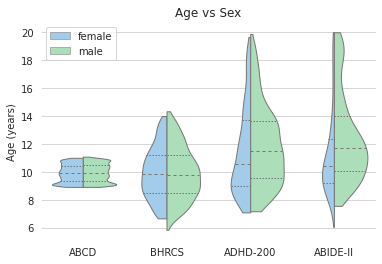

In [92]:
# plot seaborn violin plot
sn.set_palette("pastel")
sn.set_style('whitegrid', {'axes.edgecolor': 'white'}) 
ax = sn.violinplot(x='dataset', y='age_y', hue='gender',
                   data=df, palette=["#97CEF7","#A4E6B5"], split=True, 
                   scale="count", inner="quartile", cut=0, linewidth=1)
ax.set_title('Age vs Sex')
ax.set_ylabel('Age (years)')
ax.set_xlabel("")
ax.legend().set_title('')
ax.legend(loc='upper left')

plt.savefig('/project/src/python/eda/Age_vs_Sex.png', bbox_inches='tight', dpi=200)

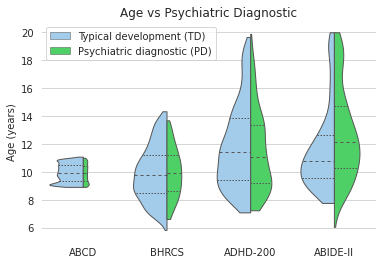

In [97]:
# plot seaborn violin plot
sn.set_palette("pastel")
sn.set_style('whitegrid', {'axes.edgecolor': 'white'}) 

ax = sn.violinplot(x='dataset', y='age_y', hue='psy', hue_order=['Typical development (TD)','Psychiatric diagnostic (PD)'],
                   data=df, palette=["#97CEF7","#39E659"], split=True,
                   scale="count", inner="quartile", cut=0, linewidth=1)
ax.set_title('Age vs Psychiatric Diagnostic')
ax.set_ylabel("Age (years)")
ax.set_xlabel('')
ax.legend().set_title('')
ax.legend(loc='upper left')

plt.savefig('/project/src/python/eda/Age_vs_Pd.png', bbox_inches='tight', dpi=200)

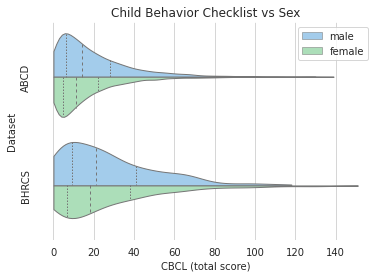

In [94]:
# plot seaborn violin plot
sn.set_palette("pastel")
sn.set_style('whitegrid', {'axes.edgecolor': 'white'}) 

ax = sn.violinplot(y='dataset', x='cbcl_tot', hue='gender', hue_order=['male','female'],
                   data=df[df['cbcl_tot']!=-999], palette=["#97CEF7","#A4E6B5"], split=True,
                   scale="count", inner="quartile", cut=0, linewidth=1)
ax.set_title('Child Behavior Checklist vs Sex')
ax.set_xlabel("CBCL (total score)")
ax.set_ylabel('Dataset')
ax.set_yticklabels(ax.get_yticklabels(), rotation=90, horizontalalignment='right', verticalalignment='center')
ax.legend().set_title('')
ax.legend(loc='upper right')

plt.savefig('/project/src/python/eda/Cbcl_vs_Sex.png', bbox_inches='tight', dpi=200)

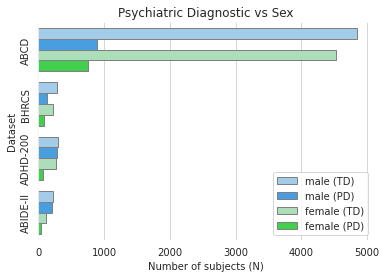

In [95]:
woman_td = (df['sex_bin'] == 0) & (df['apd'] == 0)
woman_apd = (df['sex_bin'] == 0) & (df['apd'] == 1)
man_td = (df['sex_bin'] == 1) & (df['apd'] == 0)
man_apd = (df['sex_bin'] == 1) & (df['apd'] == 1)
df['sex_diag'] = np.select([woman_td, woman_apd, man_td, man_apd],
                           ['female (TD)','female (PD)','male (TD)', 'male (PD)'],
                           'other')

sn.set_palette("pastel")
sn.set_style('whitegrid', {'axes.edgecolor': 'white'}) 

# palette=["#97CEF7","#A4E6B5"]
plot_palette = ['#97CEF7', '#2FA2F7', '#A4E6B5', '#2BE63B']
ax = sn.countplot(data=df,  y='dataset', hue='sex_diag', 
                  hue_order=['male (TD)', 'male (PD)', 'female (TD)','female (PD)'],
                  palette=plot_palette, edgecolor='gray', linewidth=1)

ax.set_title('Psychiatric Diagnostic vs Sex')
ax.set_ylabel('Dataset')
ax.set_xlabel('Number of subjects (N)')
ax.set_yticklabels(ax.get_yticklabels(), rotation=90, horizontalalignment='right', verticalalignment='center')
ax.legend().set_title('')
ax.legend(loc='lower right')

plt.savefig('/project/src/python/eda/Psy_vs_Sex.png', bbox_inches='tight', dpi=200)

In [65]:
# # generate csv files to confound analysis
# for dataset in ['ADHD200','ABIDE2','BHRC','ABCD']:
#     N = 11 if dataset == 'ABCD' else 6
#     task_list = ['AGE','ADHD'] if dataset == 'ADHD200' else ['AGE']
#     for task in task_list:
#         for i in np.arange(1,N,1):
#             # csv filenames
#             csv_predictions = '/project/data/results/predictions_csv/' + dataset \
#                                 + '_'+ task + '_k' + str(i).zfill(2) + '_predictions.csv'
#             csv_voxsum = '/project/data/results/predictions_csv/' + dataset \
#                             + '_voxels_sum.csv'
#             csv_predconfounds = '/project/data/results/predictions_csv/pred_confounds/' + dataset \
#                                     + '_' + task + '_k' + str(i).zfill(2) + '_predconfounds.csv'
#             # selected columns
#             if task == 'AGE':
#                 columns = ['predicted','target','sex_bin','site','voxels_sum']
#                 new_columns = ['prediction','target','cnf_cat_sex','cnf_cat_site','cnf_cont_voxsum']
#             else:
#                 columns = ['predicted','target','age_y','sex_bin','site','voxels_sum']
#                 new_columns = ['prediction','target','cnf_cont_age','cnf_cat_sex','cnf_cat_site','cnf_cont_voxsum']               

#             df_predconf = pd.read_csv(csv_predictions)
#             df_voxsum = pd.read_csv(csv_voxsum)
            
#             # adjust subjectid dtype for dataframe merge
#             if dataset == 'ABCD':
#                 df_predconf['subjectid'] = df_predconf['subjectid'].str.replace("b'","").str.replace("'","").astype(str)
#                 df_voxsum['subjectid'] = df_voxsum['subjectid'].str.replace("b'","").str.replace("'","").astype(str)
#             # merge dataframes and adjust column names
#             df_predconf = pd.merge(df_predconf, df_voxsum, on='subjectid')
#             df_predconf = pd.merge(df_predconf, eval('df_'+dataset.lower()), on='subjectid')
#             df_predconf = df_predconf[columns]
#             df_predconf.columns = new_columns
#             # save csvs
#             df_predconf.to_csv(csv_predconfounds, index=False, na_rep='')
#             print(csv_predconfounds) 